In [1]:
import kagglehub
path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

100%|██████████| 60.3M/60.3M [00:07<00:00, 8.30MB/s]

Extracting files...


Path to dataset files: C:\Users\Faculty\.cache\kagglehub\datasets\msambare\fer2013\versions\1


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Data Augmentation and Rescaling
train_aug = ImageDataGenerator(horizontal_flip=True,
                               shear_range=0.2,
                               zoom_range=0.2,
                               rescale=1./255)

test_aug = ImageDataGenerator(rescale=1./255)

train_df = train_aug.flow_from_directory(directory=r'C:\Users\Faculty\.cache\kagglehub\datasets\msambare\fer2013\versions\1\train',
                                         target_size=(48, 48),
                                         batch_size=32,
                                         class_mode='categorical')

test_df = test_aug.flow_from_directory(directory=r'C:\Users\Faculty\.cache\kagglehub\datasets\msambare\fer2013\versions\1\test',
                                       target_size=(48, 48),
                                       batch_size=32,
                                       class_mode='categorical')

# Load ResNet152V2 without the top layer
resnet = ResNet152V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze all layers initially
for layer in resnet.layers:
    layer.trainable = False

# Custom Model Architecture
inputs = tf.keras.Input(shape=(48, 48, 3))
resized_inputs = layers.Lambda(lambda x: tf.image.resize(x, (224, 224)))(inputs)
base_model_output = resnet(resized_inputs, training=False)

x = layers.GlobalAveragePooling2D()(base_model_output)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(7, activation='softmax')(x)

# Define the Full Model
model = Model(inputs=inputs, outputs=outputs)

# Compile the Model for Phase 1 (Frozen Base)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='fer2013_resnet_frozen.keras', 
                                                monitor='val_accuracy', save_best_only=True, mode='max')

# Phase 1: Train with Frozen Base
print("\nTraining with Frozen Base Layers (Phase 1)...")
history_frozen = model.fit(train_df,
                           epochs=20,
                           validation_data=test_df,
                           callbacks=[early_stopping, checkpoint],
                           verbose=1)

# Evaluate Phase 1
frozen_eval = model.evaluate(test_df)
print(f"\nAccuracy Before Fine-Tuning: {frozen_eval[1] * 100:.2f}%")

# Unfreeze some layers of ResNet152V2 for Fine-Tuning
for layer in resnet.layers[-30:]:  # Adjust the range of layers to unfreeze
    layer.trainable = True

# Compile the Model for Phase 2 (Fine-Tuning)
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Phase 2: Fine-Tuning
print("\nFine-Tuning the Model (Phase 2)...")
checkpoint_finetuned = tf.keras.callbacks.ModelCheckpoint(filepath='fer2013_resnet_finetuned.keras', 
                                                          monitor='val_accuracy', save_best_only=True, mode='max')
history_finetuned = model.fit(train_df,
                              epochs=30,
                              validation_data=test_df,
                              callbacks=[early_stopping, checkpoint_finetuned],
                              verbose=1)

# Evaluate Phase 2
finetuned_eval = model.evaluate(test_df)
print(f"\nAccuracy After Fine-Tuning: {finetuned_eval[1] * 100:.2f}%")


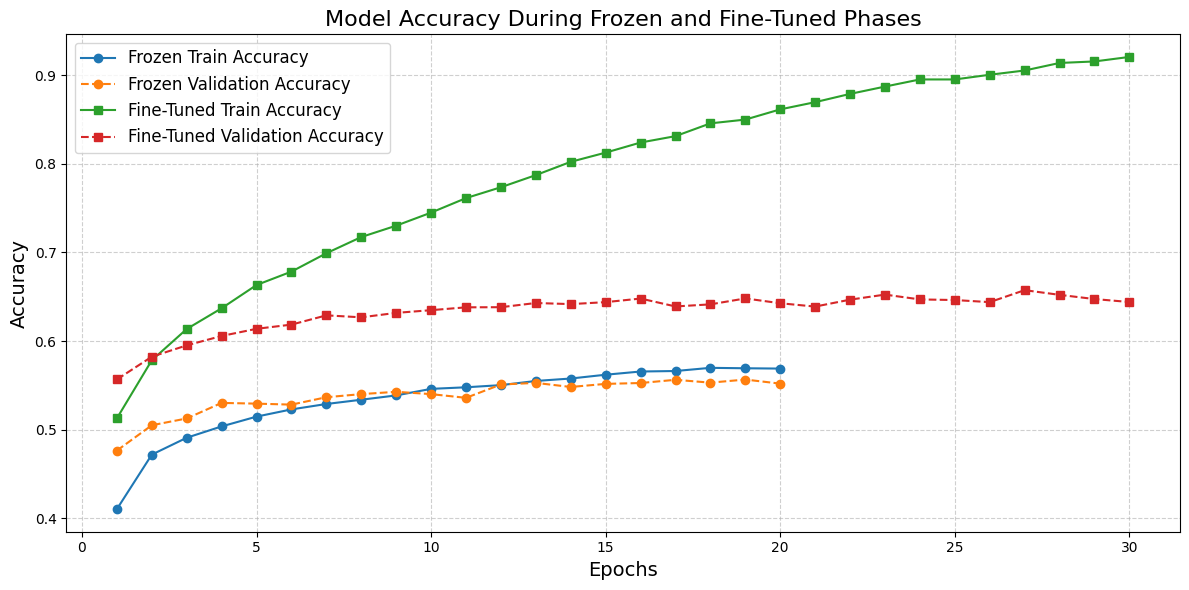

In [5]:
import matplotlib.pyplot as plt

# Example data for frozen and fine-tuned phases
# Use the dictionaries directly as you already have the data
frozen_acc = history_frozen['accuracy']
frozen_val_acc = history_frozen['val_accuracy']
frozen_epochs = range(1, len(frozen_acc) + 1)

finetuned_acc = history_finetuned['accuracy']
finetuned_val_acc = history_finetuned['val_accuracy']
finetuned_epochs = range(1, len(finetuned_acc) + 1)

# Plot the accuracy for both frozen and fine-tuned phases
plt.figure(figsize=(12, 6))

# Frozen model accuracy
plt.plot(frozen_epochs, frozen_acc, label='Frozen Train Accuracy', marker='o', linestyle='-')
plt.plot(frozen_epochs, frozen_val_acc, label='Frozen Validation Accuracy', marker='o', linestyle='--')

# Fine-tuned model accuracy
plt.plot(finetuned_epochs, finetuned_acc, label='Fine-Tuned Train Accuracy', marker='s', linestyle='-')
plt.plot(finetuned_epochs, finetuned_val_acc, label='Fine-Tuned Validation Accuracy', marker='s', linestyle='--')

# Plot settings
plt.title('Model Accuracy During Frozen and Fine-Tuned Phases', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()
